<a href="https://colab.research.google.com/github/graphlit/graphlit-samples/blob/main/python/Notebook%20Examples/Graphlit_2024_09_14_Publish_Story_Graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Description**

This example shows how to ingest the text of a story, and compare how different LLMs create a knowledge graph from the elements of the story.

**Requirements**

Prior to running this notebook, you will need to [signup](https://docs.graphlit.dev/getting-started/signup) for Graphlit, and [create a project](https://docs.graphlit.dev/getting-started/create-project).

You will need the Graphlit organization ID, preview environment ID and JWT secret from your created project.

Assign these properties as Colab secrets: GRAPHLIT_ORGANIZATION_ID, GRAPHLIT_ENVIRONMENT_ID and GRAPHLIT_JWT_SECRET.


---

Install Graphlit Python client SDK

In [48]:
!pip install --upgrade graphlit-client

Install Graphviz

In [49]:
!pip install --upgrade graphviz

Initialize Graphlit

In [50]:
import os
from google.colab import userdata
from graphlit import Graphlit
from graphlit_api import input_types, enums, exceptions

os.environ['GRAPHLIT_ORGANIZATION_ID'] = userdata.get('GRAPHLIT_ORGANIZATION_ID')
os.environ['GRAPHLIT_ENVIRONMENT_ID'] = userdata.get('GRAPHLIT_ENVIRONMENT_ID')
os.environ['GRAPHLIT_JWT_SECRET'] = userdata.get('GRAPHLIT_JWT_SECRET')

graphlit = Graphlit()

Define Graphlit helper functions

In [51]:
from typing import List, Optional

async def create_openai_specification(model: enums.OpenAIModels):
    if graphlit.client is None:
        return;

    input = input_types.SpecificationInput(
        name="OpenAI",
        type=enums.SpecificationTypes.EXTRACTION,
        serviceType=enums.ModelServiceTypes.OPEN_AI,
        openAI=input_types.OpenAIModelPropertiesInput(
            model=model
        )
    )

    try:
        response = await graphlit.client.create_specification(input)

        return response.create_specification.id if response.create_specification is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

    return None

async def create_anthropic_specification():
    if graphlit.client is None:
        return;

    input = input_types.SpecificationInput(
        name="Anthropic",
        type=enums.SpecificationTypes.EXTRACTION,
        serviceType=enums.ModelServiceTypes.ANTHROPIC,
        anthropic=input_types.AnthropicModelPropertiesInput(
            model=enums.AnthropicModels.CLAUDE_3_5_SONNET
        )
    )

    try:
        response = await graphlit.client.create_specification(input)

        return response.create_specification.id if response.create_specification is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

    return None

async def ingest_uri(uri: str):
    if graphlit.client is None:
        return;

    try:
        # Using synchronous mode, so the notebook waits for the content to be ingested
        response = await graphlit.client.ingest_uri(uri=uri, is_synchronous=True)

        return response.ingest_uri.id if response.ingest_uri is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

async def get_content(content_id: str):
    if graphlit.client is None:
        return;

    try:
        response = await graphlit.client.get_content(content_id)

        return response.content
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

async def delete_content(content_id: str):
    if graphlit.client is None:
        return;

    _ = await graphlit.client.delete_content(content_id)

async def publish_content(content_id: str, specification_id: str, prompt: str, summary_prompt: Optional[str] = None):
    if graphlit.client is None:
        return;

    try:
        response = await graphlit.client.publish_contents(
            name="Published Summary",
            connector=input_types.ContentPublishingConnectorInput(
               type=enums.ContentPublishingServiceTypes.TEXT,
               format=enums.ContentPublishingFormats.TEXT
            ),
            summary_prompt=summary_prompt,
            summary_specification=input_types.EntityReferenceInput(
                id=specification_id
            ),
            publish_prompt = prompt,
            publish_specification=input_types.EntityReferenceInput(
                id=specification_id
            ),
            filter=input_types.ContentFilter(
                id=content_id
            ),
            is_synchronous=True
        )

        return response.publish_contents if response.publish_contents is not None else None
    except exceptions.GraphQLClientError as e:
        print(str(e))
        return None

async def delete_all_contents():
    if graphlit.client is None:
        return;

    _ = await graphlit.client.delete_all_contents(is_synchronous=True)

In [52]:
from IPython.display import display, Markdown, HTML, Image
import time
from graphviz import Source
import re

# Remove any existing contents; only needed for notebook example
await delete_all_contents()

print('Deleted all contents.')

uri = "https://www.gutenberg.org/cache/epub/236/pg236-images.html"

summary_prompt = """
Identify the top 50 characters or locations (i.e. places) found in the story. Write detailed, verbose bullet points for each.

Identify the top 50 plot points which occur between the characters.

For example, in The Jungle Book, Mowgli is a 'character' and the jungle and the beach are 'locations'.

These details will be later used to generate an overall knowledge graph of the story.
"""
prompt = """
Generate a detailed knowledge graph of the storyline, relating the top 50 characters and story locations to plot points.

Edges should be the plot points; nodes should be the characters and locations. Ignore anything unrelated to the storyline.

Make sure to interconnect all the entities, where possible, as relevant to the storyline.

Output the knowledge graph in Graphviz DOT format, as plain text.
Nodes should be circles.  Characters should have Light Blue background color, and locations should have Yellow background color. Use a modern font, like Inter.
Use quoted descriptive phrases for nodes and edges, rather than snake case terms. Remember, each line in DOT format needs to end with a semicolon.
"""

Deleted all contents.


In [53]:
specification_id = await create_anthropic_specification()

if specification_id is not None:
    print(f'Created Anthropic specification [{specification_id}]:')

    content_id = await ingest_uri(uri=uri)

    if content_id is not None:
        content = await get_content(content_id)

        if content is not None:
            display(Markdown(f'### Publishing Content [{content.id}]: {content.name}...'))

            published_content = await publish_content(content_id, specification_id, prompt, summary_prompt)

            if published_content is not None:
                display(Markdown(f'### Published with Anthropic [{published_content.name}]'))

                if published_content.markdown is not None:
                    print(published_content.markdown)

                    src = Source(published_content.markdown)
                    src.render('anthropic_dot', format='png')

                    display(Image('anthropic_dot.png', width=1400))

        await delete_content(content_id)

Created Anthropic specification [9f4538cf-19ea-46fc-9ea5-08b2b397d832]:


### Publishing Content [b2ba6f41-9f6e-4494-83d4-4a315d98160a]: The Project Gutenberg eBook of The Jungle Book, by Rudyard Kipling...

### Published with Anthropic [Published Summary]

digraph {
  graph [fontname="Inter"];
  node [shape=circle, fontname="Inter"];

  "Mowgli" [style=filled, fillcolor=lightblue];
  "Bagheera" [style=filled, fillcolor=lightblue];
  "Baloo" [style=filled, fillcolor=lightblue];
  "Shere Khan" [style=filled, fillcolor=lightblue];
  "Akela" [style=filled, fillcolor=lightblue];
  "Father Wolf" [style=filled, fillcolor=lightblue];
  "Mother Wolf" [style=filled, fillcolor=lightblue];
  "Kaa" [style=filled, fillcolor=lightblue];
  "Bandar-log" [style=filled, fillcolor=lightblue];
  "Kotick" [style=filled, fillcolor=lightblue];
  "Rikki-Tikki-Tavi" [style=filled, fillcolor=lightblue];
  "Little Toomai" [style=filled, fillcolor=lightblue];

  "Seeonee Hills" [style=filled, fillcolor=yellow];
  "Council Rock" [style=filled, fillcolor=yellow];
  "Cold Lairs" [style=filled, fillcolor=yellow];
  "Man-village" [style=filled, fillcolor=yellow];
  "Novastoshnah Beach" [style=filled, fillcolor=yellow];
  "Hidden Beach" [style=filled, fillcolor=yellow];
 

Created OpenAI GPT-4o specification [c55a06fd-e1cf-484a-97dd-1d95b3c61324]:


### Publishing Content [40d47f01-d634-40f3-ad9f-7aae4cc465f4]: The Project Gutenberg eBook of The Jungle Book, by Rudyard Kipling...

### Published with OpenAI [Published Summary]

digraph JungleBook {
    graph [fontname="Inter"];
    node [shape=circle, style=filled, fontname="Inter"];

    "Mowgli" [label="Mowgli", fillcolor=lightblue];
    "Father Wolf" [label="Father Wolf", fillcolor=lightblue];
    "Mother Wolf" [label="Mother Wolf", fillcolor=lightblue];
    "Shere Khan" [label="Shere Khan", fillcolor=lightblue];
    "Bagheera" [label="Bagheera", fillcolor=lightblue];
    "Baloo" [label="Baloo", fillcolor=lightblue];
    "Akela" [label="Akela", fillcolor=lightblue];
    "Tabaqui" [label="Tabaqui", fillcolor=lightblue];
    "Kaa" [label="Kaa", fillcolor=lightblue];
    "Rikki-Tikki-Tavi" [label="Rikki-Tikki-Tavi", fillcolor=lightblue];
    "Nag" [label="Nag", fillcolor=lightblue];
    "Nagaina" [label="Nagaina", fillcolor=lightblue];
    "Darzee" [label="Darzee", fillcolor=lightblue];
    "Little Toomai" [label="Little Toomai", fillcolor=lightblue];
    "Big Toomai" [label="Big Toomai", fillcolor=lightblue];
    "Kala Nag" [label="Kala Nag", fillcolor=light

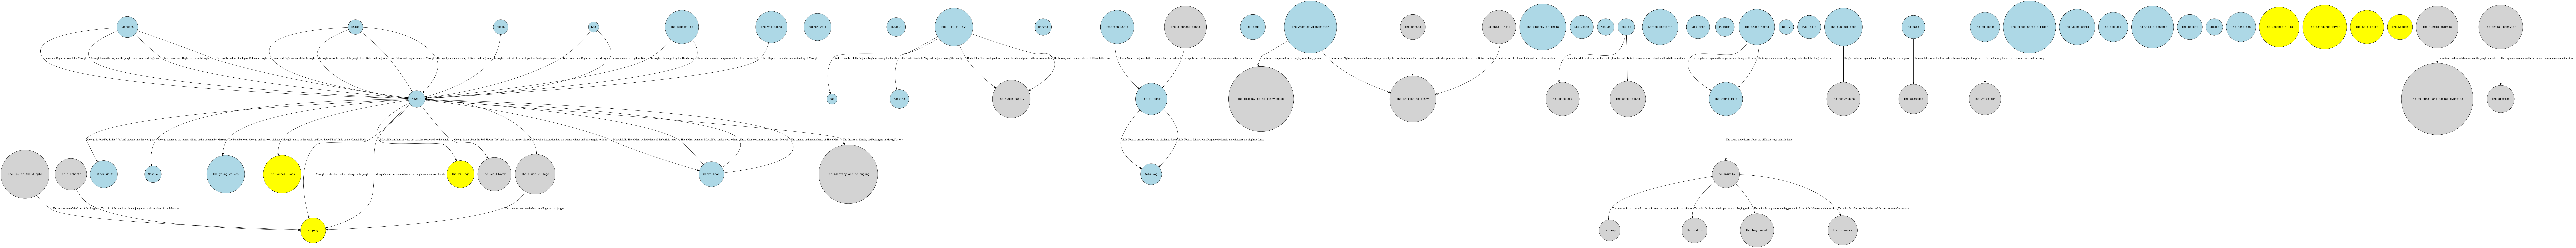

In [54]:
specification_id = await create_openai_specification(enums.OpenAIModels.GPT4O_128K)

if specification_id is not None:
    print(f'Created OpenAI GPT-4o specification [{specification_id}]:')

    content_id = await ingest_uri(uri=uri)

    if content_id is not None:
        content = await get_content(content_id)

        if content is not None:
            display(Markdown(f'### Publishing Content [{content.id}]: {content.name}...'))

            published_content = await publish_content(content_id, specification_id, prompt, summary_prompt)

            if published_content is not None:
                display(Markdown(f'### Published with OpenAI [{published_content.name}]'))

                if published_content.markdown is not None:
                    # HACK: O1 Mini keeps returning --- separator in DOT format
                    markdown = re.sub(r'^\s*---\s*$', '', published_content.markdown, flags=re.MULTILINE)

                    print(markdown)

                    src = Source(markdown)
                    src.render('openai_dot', format='png')

                    display(Image('openai_dot.png', width=1400))

        await delete_content(content_id)

In [55]:
specification_id = await create_openai_specification(enums.OpenAIModels.O1_MINI_128K)

if specification_id is not None:
    print(f'Created OpenAI o1-mini specification [{specification_id}]:')

    content_id = await ingest_uri(uri=uri)

    if content_id is not None:
        content = await get_content(content_id)

        if content is not None:
            display(Markdown(f'### Publishing Content [{content.id}]: {content.name}...'))

            published_content = await publish_content(content_id, specification_id, prompt, summary_prompt)

            if published_content is not None:
                display(Markdown(f'### Published with OpenAI [{published_content.name}]'))

                if published_content.markdown is not None:
                    # HACK: O1 Mini keeps returning --- separator in DOT format
                    markdown = re.sub(r'^\s*---\s*$', '', published_content.markdown, flags=re.MULTILINE)

                    print(markdown)

                    src = Source(markdown)
                    src.render('openai_dot', format='png')

                    display(Image('openai_dot.png', width=1400))

        await delete_content(content_id)

Created OpenAI o1-mini specification [91826053-f220-4237-9784-aeb6f1531222]:


### Publishing Content [12923c9f-3a1b-40df-8484-ba8bc0720a47]: The Project Gutenberg eBook of The Jungle Book, by Rudyard Kipling...

### Published with OpenAI [Published Summary]

digraph Storyline {
    graph [fontname="Inter"];
    node [shape=circle, fontname="Inter"];
    
    // Nodes
    "Kotick" [style=filled, fillcolor=LightBlue];
    "Rikki-Tikki-Tavi" [style=filled, fillcolor=LightBlue];
    "Nag" [style=filled, fillcolor=LightBlue];
    "Nagaina" [style=filled, fillcolor=LightBlue];
    "Little Toomai" [style=filled, fillcolor=LightBlue];
    "Kala Nag" [style=filled, fillcolor=LightBlue];
    "Mowgli" [style=filled, fillcolor=LightBlue];
    "Shere Khan" [style=filled, fillcolor=LightBlue];
    "Bagheera" [style=filled, fillcolor=LightBlue];
    "Baloo" [style=filled, fillcolor=LightBlue];
    "Kaa" [style=filled, fillcolor=LightBlue];
    "Bandar-log" [style=filled, fillcolor=LightBlue];
    "Garo Hills" [style=filled, fillcolor=Yellow];
    "Seeonee Jungle" [style=filled, fillcolor=Yellow];
    "Council Rock" [style=filled, fillcolor=Yellow];
    "Safe Islands for Seals" [style=filled, fillcolor=Yellow];
    "Family's Garden" [style=filled, fillcol